In [1]:
import numpy as np
import tensorflow as tf
import pathlib
import matplotlib.pyplot as plt
import seaborn as sns
import custom_layers
from sklearn.metrics import confusion_matrix

tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [2]:
PATH_KVASIR = 'F:\\Gastroscopies\\hyper_kvasir\\upper-gi-tract\\anatomical-landmarks'
batch_size = 32
img_height = 400
img_width = 400

In [3]:
# load pre-trained (imagenet) DenseNet model : 121 which has [6,12,24,16] layers in the 4 dense blocks
DenseNet121 = tf.keras.applications.densenet.DenseNet121(include_top=False, weights='imagenet', input_shape =(img_height, img_width, 3))

In [4]:
# tf.keras.utils.plot_model(DenseNet121, to_file='DenseNet121.png', show_shapes=True, show_layer_names=True)

In [5]:
kvasir_dir = pathlib.Path(PATH_KVASIR)

train_ds = tf.keras.utils.image_dataset_from_directory(
    kvasir_dir,
    validation_split=0.1,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
    kvasir_dir,
    validation_split=0.1,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

labels = train_ds.class_names
print(labels)

Found 2695 files belonging to 3 classes.
Using 2426 files for training.
Found 2695 files belonging to 3 classes.
Using 269 files for validation.
['pylorus', 'retroflex-stomach', 'z-line']


In [6]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
    tf.keras.layers.experimental.preprocessing.RandomFlip('vertical'),
    custom_layers.Random90Rotation()
    #tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
    #tf.keras.layers.Lambda(lambda x: tf.Tensor(np.rot90(x.numpy(), np.random.choice([-1,0,1,2]))))
])

In [7]:
resize_and_rescale = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.Resizing(img_height, img_width),
  tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
])

In [8]:
dense_end = tf.keras.Sequential([
    # https://www.pluralsight.com/guides/introduction-to-densenet-with-tensorflow
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1024,activation="relu"),
    tf.keras.layers.Dense(512,activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5)
])

prediction_layer = tf.keras.layers.Dense(3,activation='softmax')

In [9]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [10]:
inputs = tf.keras.Input(shape=(img_height, img_width, 3))
x = data_augmentation(inputs)
x = resize_and_rescale(x)
x = DenseNet121(inputs)
x = dense_end(x, training = True)
outputs = prediction_layer(x)

model = tf.keras.Model(inputs, outputs)

# initially freeze DenseNet to avoid overfitting, will unfreeze during fine-tuning 
for layer in model.layers[:-2]:
    layer.trainable=False 
    
for layer in model.layers[-2:]:
    layer.trainable=True

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.00002),
    metrics=['accuracy']
)

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 400, 400, 3)]     0         
_________________________________________________________________
densenet121 (Functional)     (None, 12, 12, 1024)      7037504   
_________________________________________________________________
sequential_2 (Sequential)    (None, 512)               1580544   
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 1539      
Total params: 8,619,587
Trainable params: 1,579,011
Non-trainable params: 7,040,576
_________________________________________________________________


(-0.5, 399.5, 399.5, -0.5)

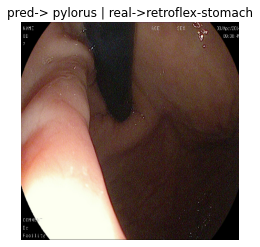

In [11]:
### TEST UNTRAINED MODEL ###
import matplotlib.pyplot as plt

image_batch, label_batch = next(iter(train_ds))
pred = model.predict(image_batch)

source = image_batch[0].numpy()/255
index_pred = np.argmax(pred[0])
index_real = label_batch[0]

plt.imshow(source)
plt.title("pred-> " + labels[index_pred]+" | real->" + labels[index_real])
plt.axis("off")

In [12]:
model.fit(
    train_ds,
    epochs=20,
    validation_data=val_ds
)

for layer in model.layers[:-2]:
    layer.trainable=True
    
model.fit(
    train_ds,
    epochs=8,
    validation_data=val_ds
)

Epoch 1/20
76/76 [==============================] - 82s 973ms/step - loss: 1.1344 - accuracy: 0.5791 - val_loss: 0.7198 - val_accuracy: 0.7138
Epoch 2/20
76/76 [==============================] - 33s 437ms/step - loss: 0.6499 - accuracy: 0.7622 - val_loss: 0.5775 - val_accuracy: 0.7993
Epoch 3/20
76/76 [==============================] - 31s 415ms/step - loss: 0.5316 - accuracy: 0.8046 - val_loss: 0.4182 - val_accuracy: 0.8513
Epoch 4/20
76/76 [==============================] - 32s 415ms/step - loss: 0.4279 - accuracy: 0.8467 - val_loss: 0.3942 - val_accuracy: 0.8773
Epoch 5/20
76/76 [==============================] - 32s 416ms/step - loss: 0.3596 - accuracy: 0.8706 - val_loss: 0.4027 - val_accuracy: 0.8848
Epoch 6/20
76/76 [==============================] - 32s 423ms/step - loss: 0.3344 - accuracy: 0.8788 - val_loss: 0.3791 - val_accuracy: 0.8662
Epoch 7/20
76/76 [==============================] - 32s 427ms/step - loss: 0.3041 - accuracy: 0.8928 - val_loss: 0.4245 - val_accuracy: 0.8476

9/9 [==============================] - 3s 349ms/step - loss: 0.2854 - accuracy: 0.9294


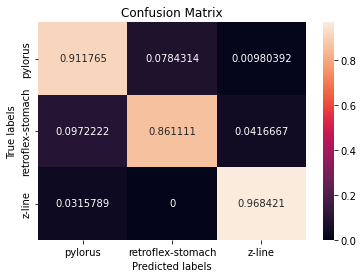

In [17]:
### model evaluation ###

model.evaluate(val_ds)
model.save('model_test.h5')

validation_iterator = iter(val_ds)
pred_label = np.array([])
true_label = np.array([])
while True:
    image_batch, label_batch = validation_iterator.get_next()
    pred_label = np.append(pred_label,model.predict(image_batch).argmax(1))
    true_label = np.append(true_label,label_batch)
    if len(image_batch) != batch_size : 
        break
        
pred_label = np.array([labels[int(x)] for x in pred_label])
true_label = np.array([labels[int(x)] for x in true_label])

cm = confusion_matrix(true_label, pred_label, normalize='true')
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(labels); ax.yaxis.set_ticklabels(labels);


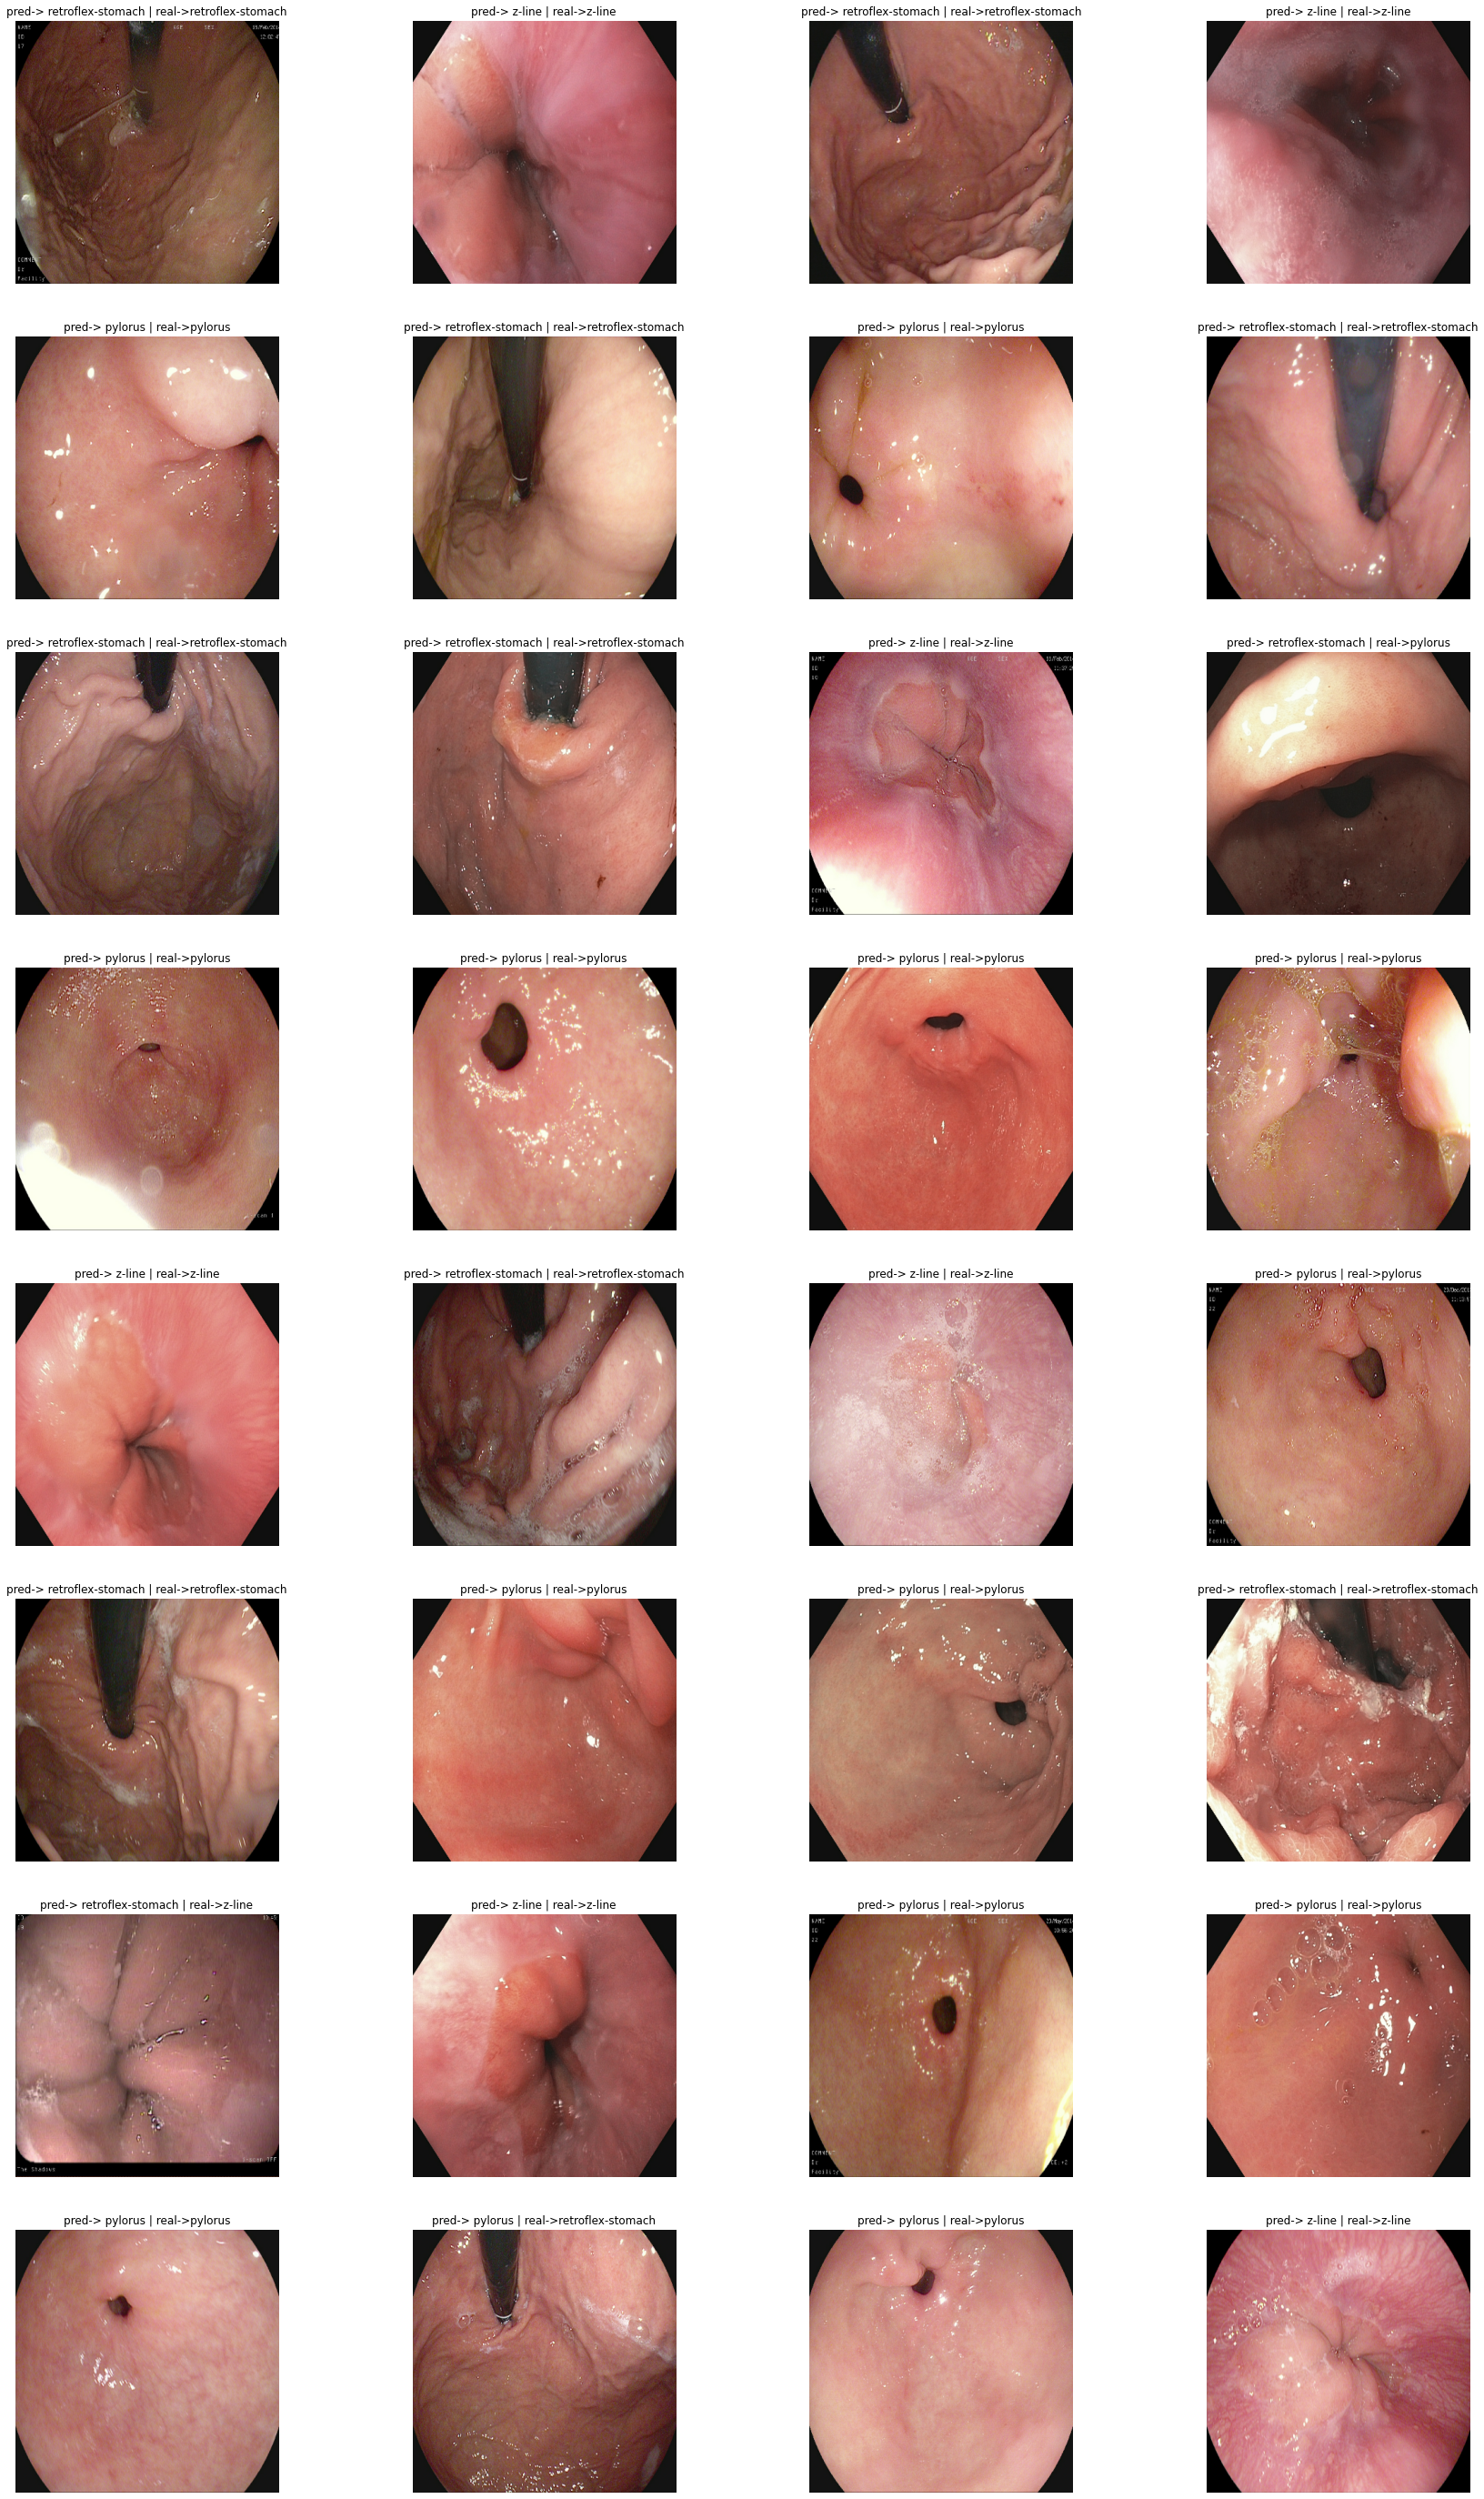

In [18]:
### EXAMPLE TRAINED MODEL ###

image_batch, label_batch = next(iter(train_ds))
pred = model.predict(image_batch)

rows, columns = 8, 4

fig = plt.figure(figsize=(30, 50))
for i in range(len(image_batch)):
    fig.add_subplot(rows,columns, i+1)
    
    source = image_batch[i].numpy()/255
    index_pred = np.argmax(pred[i])
    index_real = label_batch[i]

    plt.imshow(source)
    plt.title("pred-> " + labels[index_pred]+" | real->" + labels[index_real])
    plt.axis("off")

In [ ]:
model = tf.keras.models.load_model('./model_test.h5')